In [180]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import joblib

In [181]:
df=pd.read_csv("balanced_pediatric_diabetes_dataset.csv")

In [182]:
x=df.drop(["DiabetesRisk", "Height_cm", "Weight_kg"],axis=1)
y=df["DiabetesRisk"]

In [183]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [184]:
smote=SMOTE(random_state=42)
new_x_train,new_y_train=smote.fit_resample(x_train,y_train)

In [185]:
xgb=XGBClassifier(eval_metric='logloss',random_state=42)
rf=RandomForestClassifier(n_estimators=100,random_state=42)
ada=AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME')
lgbm = LGBMClassifier(random_state=42)

In [186]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [187]:
ada_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
}

In [188]:
xgb_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 1.0]
}

In [189]:
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(x_train, y_train)
rf_best = rf_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [190]:
ada_search = RandomizedSearchCV(ada, ada_params, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
ada_search.fit(x_train, y_train)
ada_best = ada_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [191]:
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
xgb_search.fit(x_train, y_train)
xgb_best = xgb_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [200]:
estimators=[('rf', rf_best), ('ada', ada_best),('xgb', xgb_best)]
stack=StackingClassifier(estimators=estimators, final_estimator=GradientBoostingClassifier(), passthrough=True, cv=5, n_jobs=-1)
stack.fit(new_x_train, new_y_train)

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=4,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('ada',
                                AdaBoostClassifier(algorithm='SAMME',
                                                   learning_rate=0.5,
                                                   n_estimators=150,
                                                   random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_b...
                                              interaction_constraints=None,
                                              learning_rate=0.01, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None, ...))],
                   final_estimator=GradientBoostingClassifier(), n_jobs=-1,
                   passthrough=True)

In [198]:
y_probs = stack.predict_proba(x_test)[:, 1]
threshold = 0.716
y_pred = (y_probs >= threshold).astype(int)

In [199]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       100
           1       0.74      0.73      0.73       100

    accuracy                           0.73       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.73      0.73       200



Threshold where Precision ≈ Recall: 0.716
Precision: 0.730
Recall: 0.730


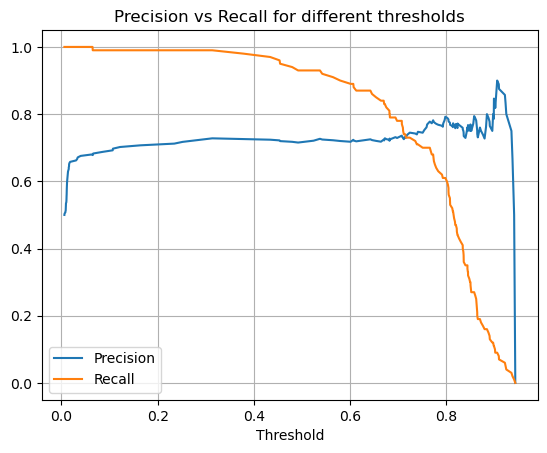

In [195]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

precision = precision[:-1]
recall = recall[:-1]

diff = np.abs(precision - recall)
best_index = np.argmin(diff)

best_threshold = thresholds[best_index]
best_precision = precision[best_index]
best_recall = recall[best_index]

print(f"Threshold where Precision ≈ Recall: {best_threshold:.3f}")
print(f"Precision: {float(best_precision):.3f}")
print(f"Recall: {float(best_recall):.3f}")

plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.title("Precision vs Recall for different thresholds")
plt.show()

In [196]:
joblib.dump(stack, 'diabetes_dataset_model.pkl')

['diabetes_dataset_model.pkl']

In [158]:
import os
os.getcwd()

'C:\\Users\\subas\\Diabetes'

In [159]:
import sklearn
print(sklearn.__version__)

1.5.1
